# Training and Back-Testing: Bitcoin Power Law Model

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
df_hist = pd.read_csv("BTC-USD-20100722-20140916.csv", index_col=0, parse_dates=True)
df_hist.rename(columns={'Close': 'price'}, inplace=True)
df_hist = df_hist.iloc[:, [3]]  # note the double brackets

start_date = df_hist.index.max() + pd.Timedelta(days=1)
end_date = dt.date.today()
symbols = ["BTC-USD"]
# After downloading:
df_yfin = yf.download("BTC-USD", start=start_date, end=end_date)['Close']  # returns a Series with dates as index
df_yfin.rename(columns={symbols[0]: 'price'}, inplace=True)

df = pd.concat([df_hist, df_yfin])

# Define the start date (Genesis Block date: January 3, 2009)
genesis_date = pd.Timestamp('2009-01-03')

# Create a 'days since genesis block' column
df['days_since_genesis'] = (df.index - genesis_date).days

# Log-transform the 'Close' price and 'days since genesis'
df['log_price'] = np.log10(df['price'])
df['log_days_since_genesis'] = np.log10(df['days_since_genesis'])

new_column_order = ['days_since_genesis', 'log_days_since_genesis', 'price', 'log_price']
df = df[new_column_order]

df.to_csv('./data/bitcoin-day-master.csv', index=True)
df

C:\Users\Enrico\AppData\Local\Temp\ipykernel_8112\3855588134.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_yfin = yf.download("BTC-USD", start=start_date, end=end_date)['Close']  # returns a Series with dates as index
[*********************100%***********************]  1 of 1 completed


,days_since_genesis,log_days_since_genesis,price,log_price
Date,,,,
2010-07-18,561,2.748963,0.100000,-1.000000
2010-07-19,562,2.749736,0.100000,-1.000000
2010-07-20,563,2.750508,0.100000,-1.000000
2010-07-21,564,2.751279,0.100000,-1.000000
2010-07-22,565,2.752048,0.100000,-1.000000
...,...,...,...,...
2025-06-28,6020,3.779596,107327.703125,5.030712
2025-06-29,6021,3.779669,108385.570312,5.034971
2025-06-30,6022,3.779741,107135.335938,5.029933


In [3]:
halving_df = pd.read_csv('./data/bitcoin-halving.csv', index_col=[0,1], parse_dates=True, date_format='%Y-%m-%d')
halving_df

0                    1  \
Type  Indicator                                                
Date  Open          2009-01-03 00:00:00  2012-11-28 00:00:00   
      High          2011-06-08 00:00:00  2013-11-29 00:00:00   
      Low           2011-10-19 00:00:00  2014-02-21 00:00:00   
      Open_to_Open      0 days 00:00:00   1425 days 00:00:00   
      Open_to_High    886 days 00:00:00    366 days 00:00:00   
      Low_to_High     886 days 00:00:00    772 days 00:00:00   
      High_to_Low     133 days 00:00:00     84 days 00:00:00   
Price Open                          0.1                 12.2   
      High                         31.9               1241.9   
      Low                           2.0                 91.7   
      Open_to_Open                  1.0   121.99999999999999   
      Open_to_High   318.99999999999994   101.79508196721312   
      Low_to_High    318.99999999999994               620.95   
      High_to_Low   0.06269592476489029  0.07383847330702954   

                                      2                    3  \
Type  Indicator                                                
Date  Open          2016-07-09 00:00:00  2020-05-11 00:00:00   
      High          2017-12-17 00:00:00  2021-11-10 00:00:00   
      Low           2018-12-15 00:00:00  2022-11-21 00:00:00   
      Open_to_Open   1319 days 00:00:00   1402 days 00:00:00   
      Open_to_High    526 days 00:00:00    548 days 00:00:00   
      Low_to_High    1395 days 00:00:00   1061 days 00:00:00   
      High_to_Low     363 days 00:00:00    376 days 00:00:00   
Price Open            666.3839721679688        8755.53515625   
      High                      20089.0            68789.625   
      Low             3191.303466796875         15599.046875   
      Open_to_Open    54.62163706294826   13.138874165543525   
      Open_to_High   30.146283282660296    7.856701363467842   
      Low_to_High     219.0730643402399   21.555338035290152   
      High_to_Low   0.15885825410905843   0.2267645284445147   

                                      4  
Type  Indicator                          
Date  Open          2024-04-20 00:00:00  
      High          2025-05-22 00:00:00  
      Low           2025-06-22 00:00:00  
      Open_to_Open   1440 days 00:00:00  
      Open_to_High    397 days 00:00:00  
      Low_to_High     913 days 00:00:00  
      High_to_Low      31 days 00:00:00  
Price Open                63851.1015625  
      High                111970.171875  
      Low                  98286.203125  
      Open_to_Open    7.292655494269919  
      Open_to_High   1.7536137848052493  
      Low_to_High     7.178013680723682  
      High_to_Low    0.8777891600874173

In [4]:
# Perform linear regression on log-transformed data
X = df['log_days_since_genesis'].values.reshape(-1, 1)  # Log of days since genesis (independent variable)
y = df['log_price'].values  # Log of Close price (dependent variable)

# Create the linear regression model
model = LinearRegression()

# Fit the model to the log-transformed data
model.fit(X, y)

# Predict the log-transformed price values
y_pred = model.predict(X)

# Calculate R-squared and Mean Squared Error for the model
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

# Print the R-squared, Mean Squared Error, intercept and slope (inclination)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")

R-squared: 0.9593393589897654
Mean Squared Error: 0.0931440336006558
Intercept: -16.441459743226652
Slope: 5.672111743511903


In [5]:
date_highs = halving_df.loc['Date', 'High'] 
df_highs = df.loc[date_highs[:4]]
df_highs
df_highs.to_csv('./data/bitcoin-day-highs.csv', index=True)

# Perform linear regression on log-transformed data
X = df_highs['log_days_since_genesis'].values.reshape(-1, 1)  # Log of days since genesis (independent variable)
y = df_highs['log_price'].values  # Log of Close price (dependent variable)

# Create the linear regression model
model_highs = LinearRegression()

# Fit the model to the log-transformed data
model_highs.fit(X, y)

# Predict the log-transformed price values
y_pred_highs = model_highs.predict(X)

# Calculate R-squared and Mean Squared Error for the model
r2 = r2_score(y, y_pred_highs)
mse = mean_squared_error(y, y_pred_highs)

y_highs_line = model_highs.coef_[0] * df['log_days_since_genesis'].values + model_highs.intercept_

# Print the R-squared, Mean Squared Error, intercept and slope (inclination)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Intercept: {model_highs.intercept_}")
print(f"Slope: {model_highs.coef_[0]}")

R-squared: 0.9942259076660853
Mean Squared Error: 0.009519695848716814
Intercept: -12.185092567232626
Slope: 4.66048742547617


In [6]:
# Intercept for the new model should be the midpoint of the intercepts of model and model_highs
intercept_high_mid_log = (10**model.intercept_ + 10**model_highs.intercept_) *.75
intercept_high_mid = np.log10(intercept_high_mid_log)

# Now create the new model_highs_mid with this intercept
# We will use the same slope as model_highs for simplicity or calculate an average slope if needed

slope_high_mid = model_highs.coef_[0]

# Predict the log-transformed price values using the new intercept and the slope
y_pred_highs_mid = slope_high_mid * df['log_days_since_genesis'].values + intercept_high_mid

print(f"Intercept: {intercept_high_mid}")
print(f"Slope: {slope_high_mid}")

Intercept: -12.310007237774991
Slope: 4.66048742547617


In [7]:
date_lows = halving_df.loc['Date', 'Low']
df_lows = df.loc[date_lows[:4]]
df_lows
df_lows.to_csv('./data/bitcoin-day-lows.csv', index=True)

# Perform linear regression on log-transformed data
X = df_lows['log_days_since_genesis'].values.reshape(-1, 1)  # Log of days since genesis (independent variable)
y = df_lows['log_price'].values  # Log of Close price (dependent variable)

# Create the linear regression model
model_lows = LinearRegression()

# Fit the model to the log-transformed data
model_lows.fit(X, y)

# Predict the log-transformed price values
y_pred_lows = model_lows.predict(X)

# Calculate R-squared and Mean Squared Error for the model
r2 = r2_score(y, y_pred_lows)
mse = mean_squared_error(y, y_pred_lows)

y_lows_line = model_lows.coef_[0] * df['log_days_since_genesis'].values + model_lows.intercept_

# Print the R-squared, Mean Squared Error, intercept and slope (inclination)
print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mse}")
print(f"Intercept: {model_lows.intercept_}")
print(f"Slope: {model_lows.coef_[0]}")

R-squared: 0.9959379094721614
Mean Squared Error: 0.008812621638017317
Intercept: -16.033801149071707
Slope: 5.481363847166391


In [8]:
# Intercept for the new model should be adjusted based on the low line instead of the high line
# 75% of the difference between the model and model_lows

intercept_low_mid_log = (10**model.intercept_ + 10**model_lows.intercept_) * 0.75
intercept_low_mid = np.log10(intercept_low_mid_log)

# Now create the new model_lows_mid with this intercept
# We will use the same slope as model_lows for simplicity

slope_low_mid = model_lows.coef_[0]

# Predict the log-transformed price values using the new intercept and the slope
y_pred_lows_mid = slope_low_mid * df['log_days_since_genesis'].values + intercept_low_mid

# Print the intercept and slope for verification
print(f"Intercept: {intercept_low_mid}")
print(f"Slope: {slope_low_mid}")

Intercept: -16.015366467897042
Slope: 5.481363847166391


In [9]:
# Create the log-log plot using Plotly
fig = go.Figure()

# Add the actual log-transformed BTC price trace
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=df['log_price'],
    mode='lines',
    name='Log10 of BTC Price',
    line=dict(color='black')
))

# Add the fitted linear regression line trace
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_pred,
    mode='lines',
    name='Linear Regression',
    line=dict(color='blue')
))

# Add the upper band trace (highs line)
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_highs_line,
    mode='lines',
    name='Highs Line',
    line=dict(color='green')
))

# Add the lower band trace (lows line)
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_lows_line,
    mode='lines',
    name='Lows Line',
    line=dict(color='red')
))

# Add the mid band trace (mid line)
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_pred_highs_mid,
    mode='lines',
    name='Sell Line',
    line=dict(color='green', dash='dash')  # Dashed green line for mid-point
))

# Add the mid band trace (mid line)
fig.add_trace(go.Scatter(
    x=df['log_days_since_genesis'],
    y=y_pred_lows_mid,
    mode='lines',
    name='Buy Line',
    line=dict(color='red', dash='dash')  # Dashed green line for mid-point
))

# Set the title and axis labels
fig.update_layout(
    title='Power Law Fit for Bitcoin Price with Linear Regression, Upper and Lower Bands',
    xaxis_title='Log10 Days from Jan 3, 2009 (Genesis Block)',
    yaxis_title='Log10 of BTC Price',
    showlegend=True,
    height=800  # Increase the height to make the y-axis taller
)

# Add grid lines
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightGray')

# Show the plot
fig.show()

In [10]:
df['log_price_buy'] = y_pred_lows_mid
df['log_price_sell'] = y_pred_highs_mid
df['price_buy'] = 10**y_pred_lows_mid
df['price_sell'] = 10**y_pred_highs_mid

# Create a condition for when to set the position
conditions = [
    (df['price'] < df['price_buy']),   # Condition for buy (position = 1)
    (df['price'] > df['price_sell'])   # Condition for sell (position = -1)
]
# Choices based on the conditions
choices = [1, -1]
# Use np.select to assign the position based on conditions, initially setting positions
df['position'] = np.select(conditions, choices, default=np.nan)
# Forward-fill the NaN values to keep the previous position until the condition changes
df['position'] = df['position'].ffill()

df["return"] = np.log(df.price.div(df.price.shift(1)))
df["strategy"] = df.position.shift(1) * df["return"]
df["cum_return"] = df["return"].cumsum().apply(np.exp)
df["cum_strategy"] = df["strategy"].cumsum().apply(np.exp)
df.iloc[0,[9,10]] = 0
df.iloc[0,[11,12]] = 1

df

,days_since_genesis,log_days_since_genesis,price,log_price,log_price_buy,log_price_sell,price_buy,price_sell,position,return,strategy,cum_return,cum_strategy
Date,,,,,,,,,,,,,
2010-07-18,561,2.748963,0.100000,-1.000000,-0.947301,0.501500,0.112901,3.173216,1.0,0.000000,0.000000,1.000000e+00,1.000000e+00
2010-07-19,562,2.749736,0.100000,-1.000000,-0.943061,0.505104,0.114009,3.199663,1.0,0.000000,0.000000,1.000000e+00,1.000000e+00
2010-07-20,563,2.750508,0.100000,-1.000000,-0.938829,0.508703,0.115125,3.226284,1.0,0.000000,0.000000,1.000000e+00,1.000000e+00
2010-07-21,564,2.751279,0.100000,-1.000000,-0.934605,0.512294,0.116251,3.253078,1.0,0.000000,0.000000,1.000000e+00,1.000000e+00
2010-07-22,565,2.752048,0.100000,-1.000000,-0.930388,0.515880,0.117385,3.280046,1.0,0.000000,0.000000,1.000000e+00,1.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-28,6020,3.779596,107327.703125,5.030712,4.701977,5.304755,50347.405585,201722.658509,1.0,0.002232,0.002232,1.073277e+06,2.106055e+11
2025-06-29,6021,3.779669,108385.570312,5.034971,4.702372,5.305091,50393.265251,201878.873091,1.0,0.009808,0.009808,1.083856e+06,2.126813e+11
2025-06-30,6022,3.779741,107135.335938,5.029933,4.702768,5.305427,50439.159062,202035.182672,1.0,-0.011602,-0.011602,1.071353e+06,2.102280e+11


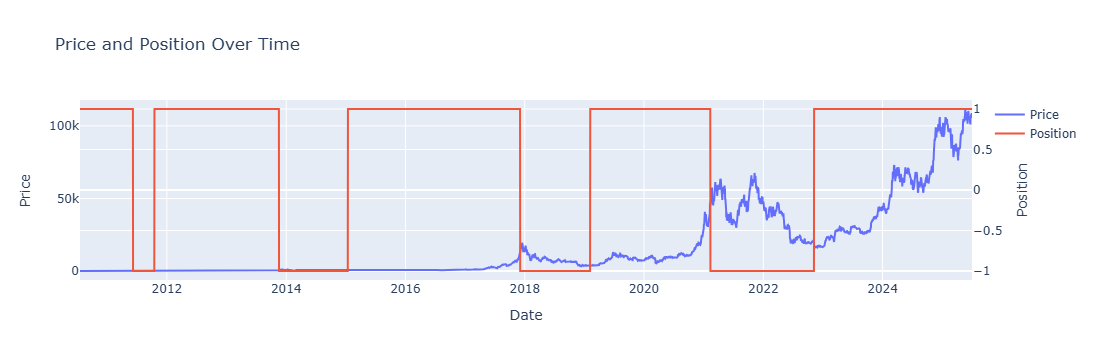

In [11]:
# Create the figure
fig = go.Figure()

# Add price line to the first y-axis
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['price'],
    mode='lines',
    name='Price'
))

# Add position line to the second y-axis
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['position'],
    mode='lines',
    name='Position',
    yaxis='y2'
))

# Update layout to add second y-axis
fig.update_layout(
    title='Price and Position Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Price', side='left'),
    yaxis2=dict(
        title='Position',
        overlaying='y',
        side='right'
    )
)

# Show the plot
fig.show()

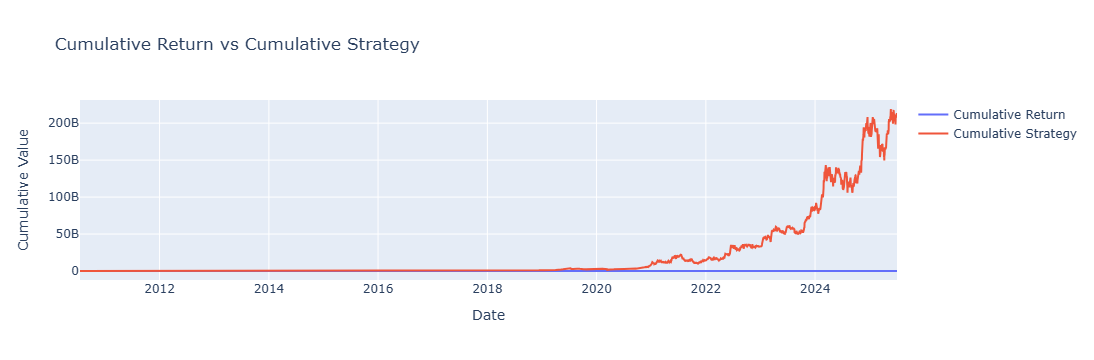

In [12]:
# Create the figure
fig = go.Figure()

# Add cumulative return line
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['cum_return'],
    mode='lines',
    name='Cumulative Return'
))

# Add cumulative strategy line
fig.add_trace(go.Scatter(
    x=df.index,
    y=df['cum_strategy'],
    mode='lines',
    name='Cumulative Strategy'
))

# Update layout
fig.update_layout(
    title='Cumulative Return vs Cumulative Strategy',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Cumulative Value')
)

# Show the plot
fig.show()